# Week 08: Dense networks with torch

## Generate nonlinear toy dataset

In [1]:
import sklearn.datasets
import sklearn.neural_network
import sklearn.model_selection
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
new_X, new_y = sklearn.datasets.make_friedman2(
    n_samples=5000,
    noise=2.0,
    random_state=7
)

In [3]:
new_X.shape

(5000, 4)

In [4]:
new_X[:, 0].shape

(5000,)

In [5]:
df_toy_data = pd.DataFrame.from_dict(
    {
        'x1': new_X[:, 0],
        'x2': new_X[:, 1],
        'x3': new_X[:, 2],
        'x4': new_X[:, 3],
        'y': new_y
    }
)

In [6]:
df_toy_data.describe()

,x1,x2,x3,x4,y
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,50.165452,935.303053,0.496215,6.000871,469.609458
std,28.939404,472.329064,0.288049,2.904397,371.794937
min,0.017656,125.699391,0.000114,1.000527,4.196304
25%,25.007474,524.011602,0.245140,3.488660,167.637529
50%,50.414687,936.064487,0.495318,5.966291,361.031424
75%,75.808676,1343.147025,0.747072,8.563639,689.287652
max,99.994040,1758.620371,0.999925,10.999195,1722.699342


In [7]:
df_toy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      5000 non-null   float64
 1   x2      5000 non-null   float64
 2   x3      5000 non-null   float64
 3   x4      5000 non-null   float64
 4   y       5000 non-null   float64
dtypes: float64(5)
memory usage: 195.4 KB


In [8]:
np.any(df_toy_data.isna())

False

## Analyze nonlinear toy dataset

In [9]:
df_subsample = df_toy_data.sample(frac=0.10, random_state=7)

In [10]:
df_subsample.describe()

,x1,x2,x3,x4,y
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,52.028985,967.584902,0.501356,6.130475,486.543740
std,28.889504,461.686904,0.288940,2.899978,368.197800
min,0.071773,126.839722,0.002199,1.007657,15.604885
25%,28.120290,586.196574,0.246261,3.586696,176.576699
50%,52.138771,998.438388,0.497678,6.046447,372.572442
75%,76.615801,1340.765941,0.751601,8.756901,736.125022
max,99.728758,1754.322561,0.994094,10.978599,1560.132269


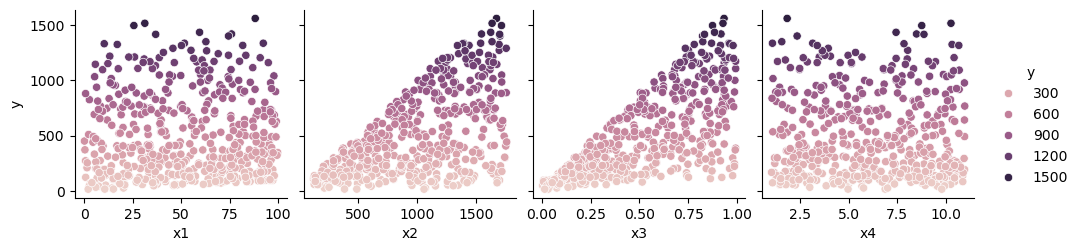

In [11]:
sns.pairplot(
    data=df_subsample,
    y_vars="y",
    hue="y"
)

## Using `skorch`

In [11]:
import torch
from torch import nn
import torch.optim
import torch.nn.functional

In [12]:
torch.manual_seed(7)
torch.cuda.manual_seed(7)

In [13]:
df_toy_data_32 = df_toy_data.astype(np.float32)
X_toy_data_32 = df_toy_data_32.drop(columns="y")
print(X_toy_data_32.shape)

(5000, 4)


In [14]:
y_toy_data_32 = df_toy_data_32["y"].values.reshape(-1,1)
print(y_toy_data_32.shape)

(5000, 1)


In [15]:
class SlayerRegressionModule(nn.Module):  # SingleDenseLayerRegressionModule(nn.Module):
    def __init__(
            self,
            n_input_columns: int,
            hidden_layer_sizes=(4, ),
            act_func=torch.nn.functional.relu,
    ):
        super().__init__()
        self.hidden_layer_sizes = hidden_layer_sizes
        self.act_func = act_func

        self.dense_input = nn.Linear(
            n_input_columns,
            self.hidden_layer_sizes[0]
        )
        self.extra_dense = torch.nn.ModuleList()
        for layer_size in self.hidden_layer_sizes:
            self.extra_dense.append(
                nn.Linear(
                    layer_size,
                    layer_size
                )
            )
            
        self.output = nn.Linear(self.hidden_layer_sizes[0], 1)

    def forward(self, X, **kwargs):
        X = self.act_func(self.dense_input(X))
        for layer in self.extra_dense:
            X = self.act_func(layer(X))
        X = self.output(X)
        return X

In [16]:
import skorch

In [17]:
new_X_train, new_X_test, new_y_train, new_y_test = sklearn.model_selection.train_test_split(
    X_toy_data_32, y_toy_data_32, test_size=0.2, random_state=7
)

In [18]:
model_toy = skorch.NeuralNetRegressor(
    SlayerRegressionModule,
    optimizer=torch.optim.Adam,
    lr=0.1,
    max_epochs=25,
    callbacks=[skorch.callbacks.EarlyStopping(
        patience=10)]
)

model_toy.module__n_input_columns = X_toy_data_32.shape[1]
model_toy.module__hidden_layer_sizes = (
    X_toy_data_32.shape[1], 
    X_toy_data_32.shape[1], 
    X_toy_data_32.shape[1]
)

In [19]:
new_X_train.values.shape

(4000, 4)

In [20]:
new_y_train.shape

(4000, 1)

In [21]:
model_toy.fit(new_X_train.values, new_y_train)  # torch can only accept numpy arrays, not DataFrames

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   354639.2963   341131.2225  0.1496
      2   276007.8591   163493.6225  0.1580
      3   144684.8259   141363.0069  0.1430
      4   140872.8709   139011.2169  0.1342
      5   141038.3753   138817.5525  0.1290
      6   141049.7178   138814.0800  0.1387
      7   141045.2706   138825.3294  0.1344
      8   141053.6781   138839.7250  0.1392
      9   141064.9734   138852.0088  0.1380
     10   141073.7259   138859.7056  0.1400
     11   141079.2137   138862.0800  0.1536
     12   141081.9759   138859.4413  0.1461
     13   141082.4803   138852.7588  0.1428
     14   141080.8503   138843.3756  0.1435
Stopping since valid_loss has not improved in the last 10 epochs.


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=SlayerRegressionModule(
    (dense_input): Linear(in_features=4, out_features=4, bias=True)
    (extra_dense): ModuleList(
      (0-2): 3 x Linear(in_features=4, out_features=4, bias=True)
    )
    (output): Linear(in_features=4, out_features=1, bias=True)
  ),
)

## Using `skorch` models with Pipeline and GridSearchCV

In [22]:
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.model_selection

Our pipeline design is based on the assumption that we have cleaned data:

1. Polynomial features, degree=2, include all feature types
2. SelectKBest, top {size of original features, i.e. 4} using mutual information
3. Robust Scaling
4. Shove it into the neural network

In [23]:
n_features_to_use = 7  # int(X_toy_data_32.shape[1])

pipeline_toy_steps = [
    ("polyfeatures", sklearn.preprocessing.PolynomialFeatures(
        degree=2,
        include_bias=True
    )),
    ("selector", sklearn.feature_selection.SelectKBest(
        score_func=sklearn.feature_selection.mutual_info_regression,
        k=n_features_to_use
    )),
    ("scaler", sklearn.preprocessing.RobustScaler()),
    ("network", skorch.NeuralNetRegressor(
        SlayerRegressionModule,
        optimizer=torch.optim.Adam,  # for some reason, Adam is more stable with polyfeatures
        lr=0.2,
        max_epochs=100,
        callbacks=[skorch.callbacks.EarlyStopping(  # trying out early stopping
            patience=10)]
    ))
]

pipeline_toy = sklearn.pipeline.Pipeline(pipeline_toy_steps)

In [24]:
pipeline_toy.named_steps["network"].module__n_input_columns = n_features_to_use
pipeline_toy.named_steps["network"].module__hidden_layer_sizes = (
    n_features_to_use, 
    n_features_to_use, 
    n_features_to_use
)

In [25]:
new_X_train.shape

(4000, 4)

In [26]:
new_y_train.shape

(4000, 1)

In [27]:
pipeline_toy.fit(new_X_train.values, new_y_train) 

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   142583.9987    44017.6472  0.1650
      2    16431.6206     4515.8453  0.1770
      3     3258.9452     1518.5925  0.1601
      4     1096.7979      712.3449  0.1566
      5      653.3953      519.4631  0.1460
      6      509.9761      430.3277  0.1503
      7      420.8207      369.3332  0.1749
      8      360.1051      315.7397  0.1490
      9      316.0256      273.3488  0.1829
     10      285.4398      242.7860  0.1565
     11      262.5596      228.3570  0.1514
     12      242.2635      220.0071  0.1556
     13      221.6017      196.4766  0.1591
     14      200.1601      173.6780  0.1322
     15      181.6307      158.0086  0.1207
     16      166.3972      144.3708  0.1386
     17      153.4845      131.1610  0.1524
     18      142.5368      120.3886  0.1853
     19      133.3197      111.3287  0.1284
     20      125.6699      103.4967  0.1471
     21      119.6067       94.9

Pipeline(steps=[('polyfeatures', PolynomialFeatures()),
                ('selector',
                 SelectKBest(k=7,
                             score_func=<function mutual_info_regression at 0x0000019BDD489C60>)),
                ('scaler', RobustScaler()),
                ('network',
                 <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=SlayerRegressionModule(
    (dense_input): Linear(in_features=7, out_features=7, bias=True)
    (extra_dense): ModuleList(
      (0-2): 3 x Linear(in_features=7, out_features=7, bias=True)
    )
    (output): Linear(in_features=7, out_features=1, bias=True)
  ),
))])

In [28]:
pipeline_toy.score(new_X_train.values, new_y_train)

0.9996456415038746

In [29]:
pipeline_toy.named_steps["network"]

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=SlayerRegressionModule(
    (dense_input): Linear(in_features=7, out_features=7, bias=True)
    (extra_dense): ModuleList(
      (0-2): 3 x Linear(in_features=7, out_features=7, bias=True)
    )
    (output): Linear(in_features=7, out_features=1, bias=True)
  ),
)

In [30]:
pipeline_toy.named_steps["polyfeatures"].get_feature_names_out()

array(['1', 'x0', 'x1', 'x2', 'x3', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3',
       'x1^2', 'x1 x2', 'x1 x3', 'x2^2', 'x2 x3', 'x3^2'], dtype=object)

In [31]:
pipeline_toy.named_steps["selector"].get_support()

array([False, False,  True,  True, False, False, False,  True, False,
        True,  True, False,  True,  True, False])

In [32]:
import sklearn.metrics
sklearn.metrics.mean_absolute_error(pipeline_toy.predict(new_X_test)[:, 0], new_y_test[:, 0])

/home/curt/mambaforge/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


8.188917

## Make sure X dataframes are converted to numpy arrays

In [33]:
import sklearn.datasets
import sklearn.model_selection
import pandas as pd
import numpy as np

In [34]:
bunch_nasa = sklearn.datasets.fetch_openml(
    data_id=42821,
    as_frame=True
)

/home/curt/mambaforge/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [35]:
type(bunch_nasa.data)

pandas.core.frame.DataFrame

In [36]:
df_X_train, df_X_test, ds_y_train, ds_y_test = sklearn.model_selection.train_test_split(
    bunch_nasa.data, bunch_nasa.target,
    test_size=0.3
)

In [37]:
type(ds_y_train)

pandas.core.series.Series

In [38]:
X_train = df_X_train.to_numpy()

In [39]:
type(X_train)

numpy.ndarray